### Comparison of a variety of neuron models 
Implementation of a standard **Leaky Integrate-and-Fire (LIF)** neuron, a **Hodgkin-Huxley** neuron, various **Izhikevich** neurons (regular spiking, intrinsically bursting, chattering, or fast spiking), and our novel **Funky** neuron (equivalent to an LIF neuron with a variable threshold).

For the LIF and Funky neuron models, the resting membrane potential, threshold potential, and membrane time constant are set to reasonable values to be comparable with biophysically realistic neurons (-65 mV, -50 mV, and 10ms, respectively.)

For each neuron type, we plot membrane voltage and spikes in response to a constant stimulus current. The magnitude of the stimulus current, number of simulated timesteps, and dt are chosen for each neuron to show roughly 10-20 spikes within the simulation period. Note that the number of required timestemps varies greatly for different neuron types (e.g. it takes only 200 timesteps for an LIF neuron to fire 15 spikes, but 20000 timesteps for a Hodgkin-Huxley neuron to fire 12 spikes).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, title=False):
  '''Plot input current, membrane potential, and spike events'''
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="orange")
  ax[0].set_ylabel("Input Current ")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylabel("Membrane Potential")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot spike events using eventplot
  spike_times = [i for i, spike in enumerate(spk) if spike == 1]
  ax[2].eventplot(spike_times, orientation='horizontal', lineoffsets=0, linelengths=1, colors='black')
  ax[2].set_ylabel("Spikes")

  plt.show()


### Leaky Integrate-and-Fire (LIF) neuron

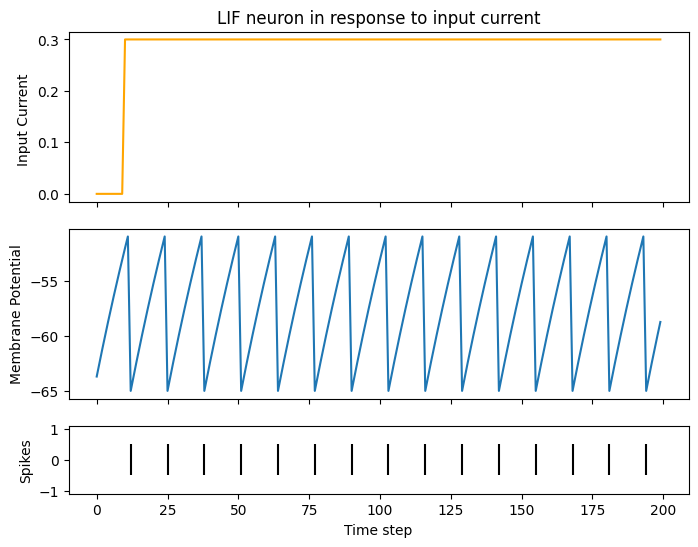

In [ ]:
R_m = 0.05    # Membrane resistance (MΩ/cm^2)
C_m = 1.0     # Membrane capacitance (uF/cm^2)
# tau_m = 10.0 ms for the above R_m and C_m, which is a reasonable value for a neuron
V_rest = -65  # Resting potential (mV)
V_thresh = -50 # Firing threshold (mV)

def leaky_integrate_and_fire(V_mem, current, 
                             V_thresh=V_thresh, V_rest=V_rest, dt=1e-3, R=R_m, C=C_m):
  '''Simulate a single step of LIF dynamics'''
  tau_mem = R*C
  V_mem = V_mem + (dt/tau_mem) * (-V_mem + current * R)
  spike = int(V_mem > V_thresh)
  # Every time we fire a spike, return to threshold
  if spike:
    V_mem = V_rest
  return V_mem, spike

num_steps = 200

# Stimulus current
current_amt = 0.3
input_current = torch.cat((torch.zeros(10), torch.ones(num_steps-10)*current_amt), 0)

# Start the membrane at rest
LIF_mem = V_rest

# Set up lists to store membrane voltage and spikes
LIF_mem_list = []
LIF_spk_list = []

# Neuron simulation
for step in range(num_steps):
  LIF_mem, spk = leaky_integrate_and_fire(LIF_mem, input_current[step])
  LIF_mem_list.append(LIF_mem)
  LIF_spk_list.append(spk)

# Plot
plot_cur_mem_spk(input_current, LIF_mem_list, LIF_spk_list, title="LIF neuron in response to input current")

### Hodgkin-Huxley neuron

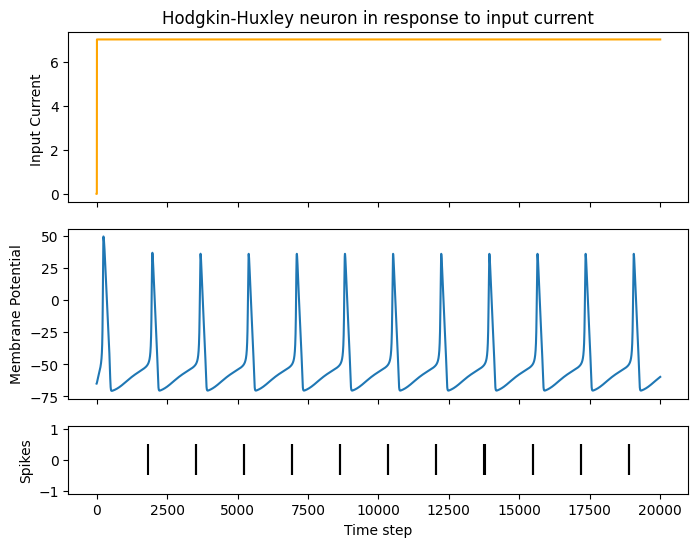

In [ ]:
C_m = 1.0           # Membrane capacitance (uF/cm^2)
g_Na_max = 120.0    # Maximum sodium conductance (mS/cm^2)
g_K_max = 36.0      # Maximum potassium conductance (mS/cm^2)
g_l = 0.3           # Leak conductance (mS/cm^2)
E_Na = 55.17        # Sodium equilibrium potential (mV)
E_K = -72.14        # Potassium equilibrium potential (mV)
E_l = -49.24        # Leak equilibrium potential (mV)

# Define rate constant functions for ion gating variables
an = lambda v: 0.01 * (-50 - v) / (np.exp((-50 - v) / 10) - 1)
Bn = lambda v: 0.125 * np.exp((-60 - v) / 80)
am = lambda v: 0.1 * (-35 - v) / (np.exp((-35 - v) / 10) - 1)
Bm = lambda v: 4 * np.exp((-60 - v) / 18)
ah = lambda v: 0.07 * np.exp((-60 - v) / 20)
Bh = lambda v: 1 / (np.exp((-30 - v) / 10) + 1)

def hodgkin_huxley(V_mem, current, m, h, n,
                   V_thresh=-50, dt=1e-2, C=C_m):
    '''Simulate a single step of Hodgkin-Huxley dynamics'''
    
    # Compute conductances
    g_Na = g_Na_max * (m ** 3) * h
    g_K = g_K_max * (n ** 4)
    
    # Compute ionic currents
    I_Na = g_Na * (V_mem - E_Na)
    I_K = g_K * (V_mem - E_K)
    I_l = g_l * (V_mem - E_l)
    
    # Update state variables
    m = m + dt * (am(V_mem) * (1 - m) - Bm(V_mem) * m) # Na subunit activation
    h = h + dt * (ah(V_mem) * (1 - h) - Bh(V_mem) * h) # Na subunit inactivation
    n = n + dt * (an(V_mem) * (1 - n) - Bn(V_mem) * n) # K subunit activation
    V_mem = V_mem - dt / C * (I_Na + I_K + I_l - current)

    # We'll define the spike time as when we hit action potential firing threshold (instead of peak)
    # (& make sure potassium conductance is low so we catch the rising edge not the falling edge)
    spike = int((abs(V_mem - V_thresh) <= 0.03) and g_K < 1)
    return V_mem, spike, m, h, n


num_steps = 20000

# Stimulus current
current_amt = 7
input_current = torch.cat((torch.zeros(10), torch.ones(num_steps-10)*current_amt), 0)

# Start the membrane at rest
HH_mem = V_rest

# Initialize gating variables for HH neuron
m = am(V_rest) / (am(V_rest) + Bm(V_rest))
h = ah(V_rest) / (ah(V_rest) + Bh(V_rest))
n = an(V_rest) / (an(V_rest) + Bn(V_rest))

# Set up lists to store membrane voltage and spikes
HH_mem_list = []
HH_spk_list = []

# Neuron simulation
for step in range(num_steps):
    HH_mem, spk, m, h, n = hodgkin_huxley(HH_mem, input_current[step], m, h, n)
    HH_mem_list.append(HH_mem)
    HH_spk_list.append(spk)

# Plot
plot_cur_mem_spk(input_current, HH_mem_list, HH_spk_list, title="Hodgkin-Huxley neuron in response to input current")

### Izhikevich neurons
The Izhikevich model is able to simulates the behavior of a variety of neuron types, including regular spiking (RS), intrinsically bursting (IB), chattering (CH), and fast spiking (FS) neurons by varying the parameters `a`, `b`, `c`, and `d`. The model is defined by 2 differential equations and an artificial reset mechanism that brings the membrane potential back to rest after a spike is fired.

See original paper and resources at: https://www.izhikevich.org/publications/spikes.htm 

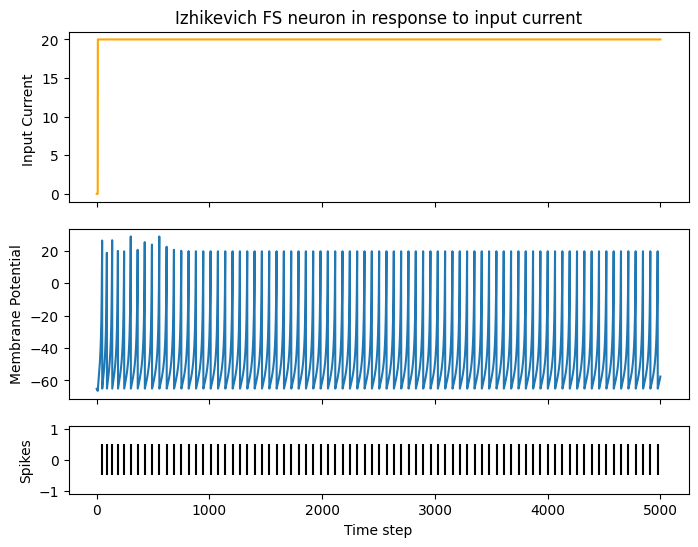

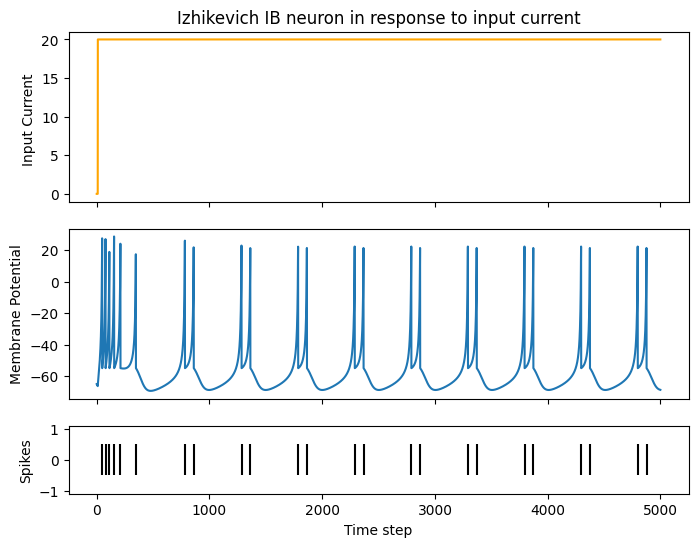

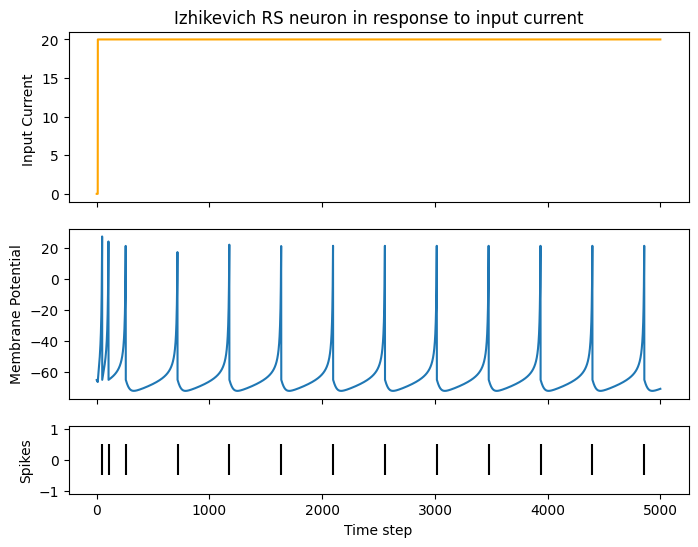

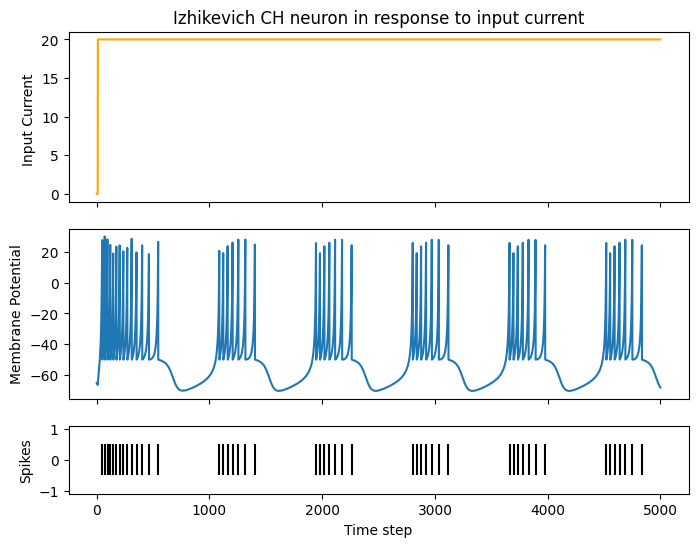

In [ ]:
# This model is technically non-dimensional, but the parameters are assumed to be in mV and ms

neuron_params = {
    # Regular spiking
    'RS': {
        'a': 0.02,
        'b': 0.2,
        'c': -65,
        'd': 8
    },
    # Intrinsically bursting
    'IB': {
        'a': 0.02,
        'b': 0.2,
        'c': -55,
        'd': 4
    },
    # Chattering
    'CH': {
        'a': 0.02,
        'b': 0.2,
        'c': -50,
        'd': 2
    },
    # Fast spiking
    'FS': {
        'a': 0.1,
        'b': 0.2,
        'c': -65,
        'd': 2
    }
}
V_max = 30

def izhikevich(V_mem, current, u, params=neuron_params['RS'], V_max=V_max, dt=5e-2):
    '''Simulate a single step of Izhikevich neuron dynamics'''

    params = neuron_params[neuron_type]

    dvdt = 0.04*V_mem**2 + 5*V_mem + 140 - u + current
    dudt = params['a']*(params['b']*V_mem - u)
  
    V_mem = V_mem + dvdt*dt
    u = u + dudt*dt
  
    spike = int(V_mem > V_max)
    if spike:
        V_mem = params['c']
        u = u + params['d']

    return V_mem, spike, u

num_steps = 5000

# Run the simulation for each neuron type
neuron_types = ['FS', 'IB', 'RS', 'CH']
for neuron_type in neuron_types:

    # Stimulus current
    current_amt = 20
    input_current = torch.cat((torch.zeros(10), torch.ones(num_steps-10)*current_amt), 0)

    # Start the membrane at rest
    Iz_mem = V_rest
    params = neuron_params[neuron_type]
    u = Iz_mem*params['b']

    # Set up lists to store membrane voltage and spikes
    Iz_mem_list = []
    Iz_spk_list = []

    # Neuron simulation
    for step in range(num_steps):
        Iz_mem, spk, u = izhikevich(Iz_mem, input_current[step], u, params=params)
        Iz_mem_list.append(Iz_mem)
        Iz_spk_list.append(spk)

    # Plot
    plot_cur_mem_spk(input_current, Iz_mem_list, Iz_spk_list, title=f"Izhikevich {neuron_type} neuron in response to input current")

### Funky neuron

The `Funky` neuron is a variation of the classic first-order leaky integrate-and-fire (LIF) neuron model.
The spike threshold is dynamically modified after each spike by an amount drawn from a normal distribution (mean=0, stddev=funkiness). When funkiness is set to 0, the Funky neuron is equivalent to a standard LIF neuron.

Increasing funkiness introduces variability in when and which neurons activate.

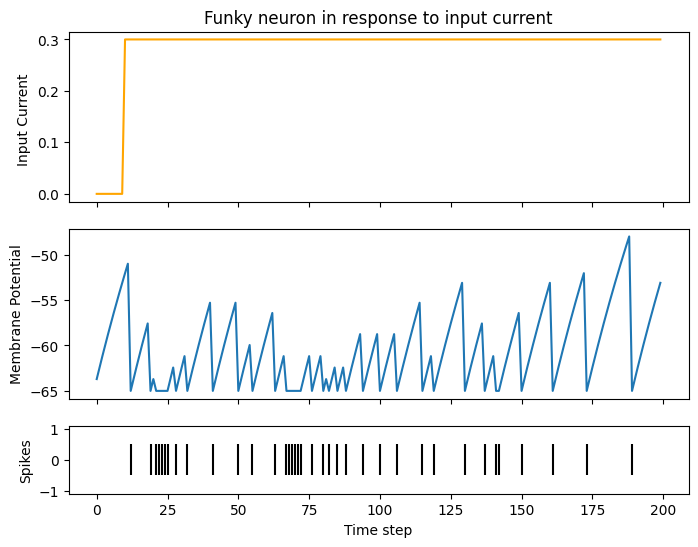

In [44]:
R_m = 0.05    # Membrane resistance (MΩ/cm^2)
C_m = 1.0     # Membrane capacitance (uF/cm^2)
# tau_m = 10.0 ms for the above R_m and C_m, which is a reasonable value for a neuron
V_rest = -65  # Resting potential (mV)
V_thresh = -50 # Firing threshold (mV)

# Funkiness controls how much the spike threshold should be modified each time a 
# spike is fired. Formally, funkiness is the standard deviation of the normal 
# distribution from which the random threshold modification is drawn.
funkiness = 4 

def funky(V_mem, current, V_thresh=V_thresh, V_rest=V_rest, dt=1e-3, R=R_m, C=C_m, funkiness=0):
  '''Simulate a single step of Funky neuron dynamics'''
  tau_mem = R*C
  V_mem = V_mem + (dt/tau_mem) * (-V_mem + current * R)
  spike = int(V_mem > V_thresh)
  # Every time we fire a spike, return to threshold
  if spike:
    V_mem = V_rest
    # Mess with the threshold randomly hehe
    V_thresh = V_thresh+np.random.normal(0, funkiness)
  return V_mem, spike, V_thresh


num_steps = 200

# Stimulus current
current_amt = 0.3
input_current = torch.cat((torch.zeros(10), torch.ones(num_steps-10)*current_amt), 0)

# Start the membrane at rest
funky_mem = V_rest
thresh = V_thresh

# Set up lists to store membrane voltage and spikes
funky_mem_list = []
funky_spk_list = []

# Neuron simulation
for step in range(num_steps):
  funky_mem, spk, thresh = funky(funky_mem, input_current[step], thresh, funkiness=funkiness)
  funky_mem_list.append(funky_mem)
  funky_spk_list.append(spk)

# Plot
plot_cur_mem_spk(input_current, funky_mem_list, funky_spk_list, title="Funky neuron in response to input current")